# Approach

Let's visualize how the most important features are behaving in luminal cancers.

In [23]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.ensemble import GradientBoostingClassifier

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

ensembl = sc.queries.biomart_annotations(org='hsapiens',
                                         attrs=['ensembl_gene_id', 'gene_biotype',
                                                'external_gene_name', 'description'])

In [24]:
df = pd.read_csv('../luminalAB/mrna/trimmedTMM.csv', index_col='geneid')
logdf = pd.read_csv('../luminalAB/mrna/logTMM.csv', index_col='geneid')
normed = pd.read_csv('../luminalAB/mrna/NormalizedlogTMM.csv', index_col='geneid')
meta = pd.read_csv('../luminalAB/mrna/lumAB_id_cancer.txt', sep='\t')
meta.ID = meta.ID.astype('category')
meta.ID.cat.set_categories(df.columns, inplace=True)
meta.sort_values("ID", inplace=True)
ensembl = ensembl[ensembl.ensembl_gene_id.isin(df.index)]

In [25]:
gbc = pd.read_csv('../luminalAB/ensemble_genes.txt', header=None, names=['gene'])
lgt = pd.read_csv('../luminalAB/logistic_genes.txt', header=None, names=['gene'])

In [26]:
intsct = np.intersect1d(gbc.gene, lgt.gene)
ens_intsct = ensembl[ensembl.external_gene_name.isin(intsct)].ensembl_gene_id.values
ens_intsct

array(['ENSG00000160298', 'ENSG00000080986', 'ENSG00000093009',
       'ENSG00000100526', 'ENSG00000153404', 'ENSG00000137310',
       'ENSG00000132182', 'ENSG00000140525', 'ENSG00000197299',
       'ENSG00000129810', 'ENSG00000161800', 'ENSG00000168329',
       'ENSG00000075702', 'ENSG00000094755', 'ENSG00000110075',
       'ENSG00000113810', 'ENSG00000169507', 'ENSG00000137699',
       'ENSG00000178999', 'ENSG00000169683'], dtype=object)

In [27]:
df = df.loc[ens_intsct]

In [72]:
tidy = df.reset_index().melt(id_vars='geneid', var_name='Sample', value_name='TMM').set_index('Sample')
tidy.shape
tidy = tidy.join(meta.set_index('ID'), how='outer').reset_index()
tidy = tidy.join(ensembl.set_index('ensembl_gene_id'), on=['geneid'], how='outer')
tidy.columns = ['Sample', 'geneid', 'TMM', 'cancer', 'gene_biotype', 'gene', 'description']
tidy['cancer'] = tidy.cancer.str.replace('_', '-')
tidy.head()

,Sample,geneid,TMM,cancer,gene_biotype,gene,description
0.0,00a2d166-78c9-4687-a195-3d6315c27574,ENSG00000160298,5.307,Luminal-B,protein_coding,C21orf58,chromosome 21 open reading frame 58 [Source:HG...
20.0,01263518-5f7c-49dc-8d7e-84b0c03a6a63,ENSG00000160298,13.336,Luminal-B,protein_coding,C21orf58,chromosome 21 open reading frame 58 [Source:HG...
40.0,01f50abf-fc15-446e-9d07-edeecc545a32,ENSG00000160298,10.237,Luminal-B,protein_coding,C21orf58,chromosome 21 open reading frame 58 [Source:HG...
60.0,02bf5203-f9cd-4c5a-97b4-e5584dc22325,ENSG00000160298,6.033,Luminal-A,protein_coding,C21orf58,chromosome 21 open reading frame 58 [Source:HG...
80.0,02f5ae33-a563-4ecb-9e33-dfa500a44931,ENSG00000160298,8.015,Luminal-A,protein_coding,C21orf58,chromosome 21 open reading frame 58 [Source:HG...


# Plot gene expression levels of important features in luminal cancer, subset to high expression levels

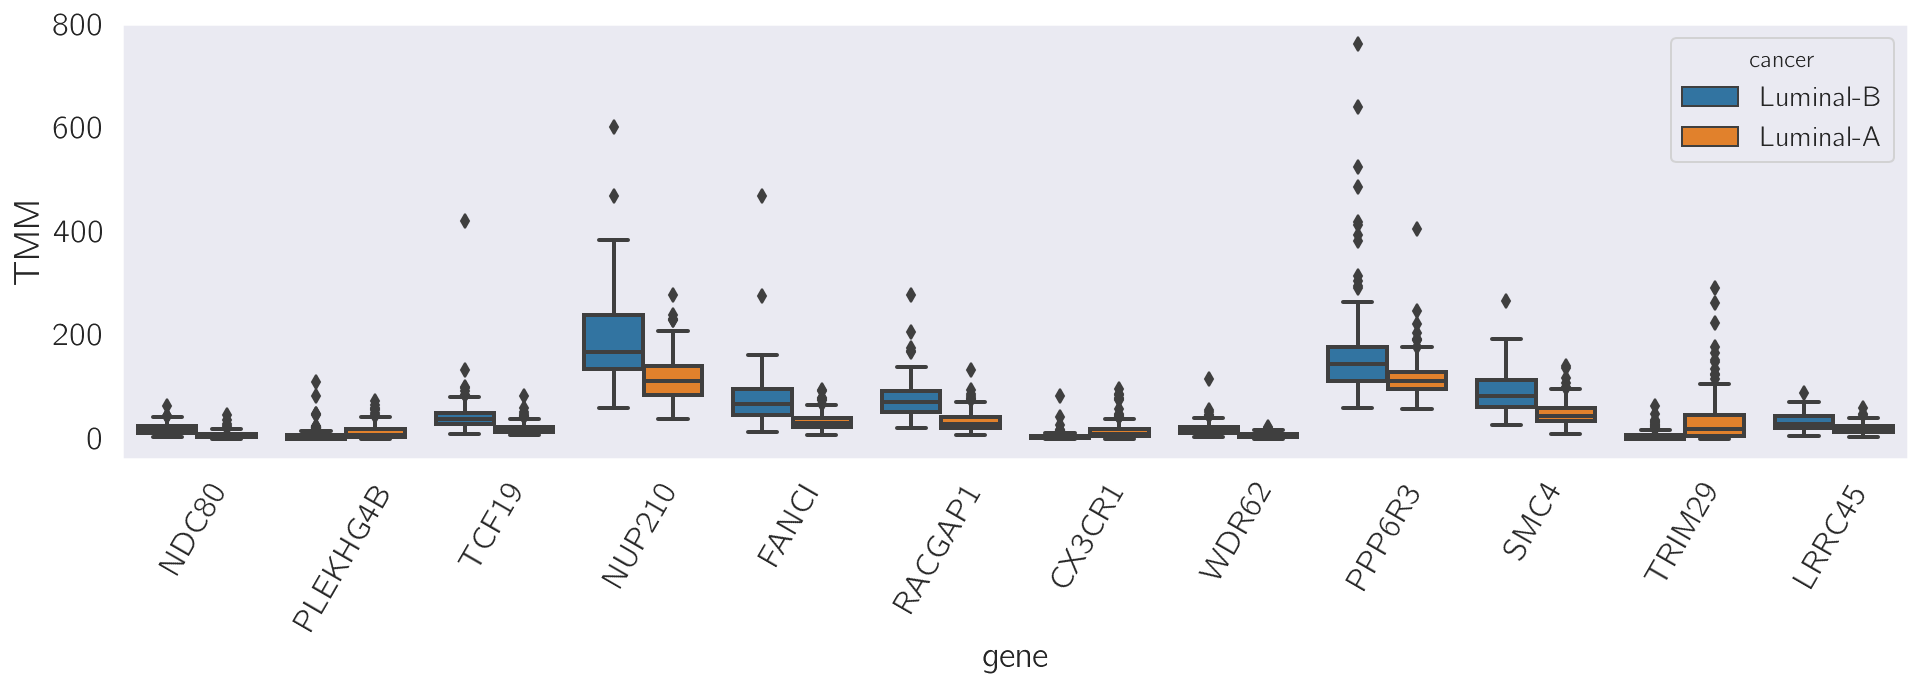

In [73]:
tidy = tidy[~tidy.geneid.str.contains('94755')]  # this has an extreme outlier that makes visualization difficult.
mean_exp = tidy.groupby('geneid').TMM.mean()
high_exp = mean_exp[mean_exp > 10].index
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxplot(y='TMM', x='gene', hue='cancer', data=tidy[tidy.geneid.isin(high_exp)])
_ = plt.xticks(rotation=60)